In [1]:
#IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing

## PART 1: MOD

In [2]:
#MODIFIER .py file eventually

import numpy as np
import matplotlib.pyplot as plt
# from Modifier import Modifier

# Define mdv as a global variable
# mdv={"domain_min_range":1, "domain_max_range":100, "modifier_incremental_unit":3, "modifier_data_point":10}


def local_modifier_A(x,new_min=0,new_max=100):
    temp = x**2
    temp = rescaler(temp,new_min,new_max)
    return temp

def local_modifier_B(x,new_min=0,new_max=100):
    temp = x*2/3
    temp = rescaler(temp,new_min,new_max)
    return temp

def rescaler(old_list,new_min,new_max):
    new_values=[]
    for old_value in old_list:
        new_values.append((((old_value - min(old_list)) * (new_max - new_min)) / (max(old_list) - min(old_list)))+ new_min)
    return new_values

def modifier_controller(range_list, local_modifier=local_modifier_A, do_plot=False):
    
    # Function to control modifiers given the input and the selected modifier function. Option to plot or not. 
    
    print("\nModifier controller...")
    print('  * Interval: ',range_list)
    all_interval_mod = []
    
    # Check if it's possible to generate more data points
    if mdv["modifier_data_point"] < mdv["modifier_incremental_unit"]:
        return False  # Exit the function if not possible
    
    for i in range(len(range_list)):
        print('iterations within Modifier: ',i)
        interval_min_range = range_list[i][0] #mdv["domain_min_range"]
        interval_max_range = range_list[i][1] #mdv["domain_max_range"]
        
        # Generate data points (incremental ticks and function modified x values) within the specified interval
        mod_ticks = np.arange(interval_min_range, interval_max_range, mdv["modifier_data_point"])
        mod_x = local_modifier(mod_ticks, new_min=interval_min_range,new_max=interval_max_range)
        
        # Normalize the function outputs to fit within the interval range
        # mod_x = rescaler(mod_x, new_max=interval_max_range, new_min=interval_min_range)
        all_interval_mod.append(mod_x)
    
    # update the mdv to decrease the interdatapoint distance for the next iteration
    mdv["modifier_data_point"] = mdv["modifier_data_point"] - mdv["modifier_incremental_unit"]
    
    if do_plot == True:
        # Plot the generated data points
        for mod_x in all_interval_mod:
            plt.scatter(mod_x, np.ones(np.shape(mod_x)))
            plt.show()
    
    print('  * Mod_x:   ',all_interval_mod)
    return all_interval_mod


## PART 2: SIM

In [2]:
# import numpy as np

# def sim_func_A(x):
#     print('\nthis should be a single point: ',x)
#     noise = np.random.normal(-10000, 10000, 1)
#     return float(x**3 - x**2 + noise)

# def sim_func_B(x):
#     return float(x * 2 / 3)

# def simulator_controller(mod_x, selected_function=sim_func_A):
#     print("\nSimulator...")
#     # shape_mod_x = np.shape(mod_x)
#     if mod_x is False: 
#         return False  # Possible iterations have ended
    
#     flat_mod_x = [item for sublist in mod_x for item in sublist]
#     # flat_mod_x = np.reshape(mod_x,shape_mod_x[0]*shape_mod_x[1])
#     # print(flat_mod_x)
#     simulated_y = [selected_function(x) for x in flat_mod_x]
    

#     print('  * Sim_y:   ', simulated_y)
#     # print('  * Sim_y shape:   ', np.shape(simulated_y))
#     # return mod_x, simulated_y
#     return flat_mod_x, simulated_y


## Part 3: VALIDATOR test
modifier and simulator working in dynamic way, with hardcoded ranges
* next step, extract the ranges 



In [4]:
# DRAFT TEMP FUNCTIONS that will be in validator once they work as intended
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures

def get_range(x_values,outliers,delta=0.7):
    x_values = np.array(x_values)
    relative_max = x_values[-1]
    relative_min = x_values[0]
    
    # Calculate ranges of outliers
    outlier_ranges = []

    current_range = [outliers[0]]
    print('current range: ',current_range)

    for i in range(1, len(outliers)):
        x_outlier_ranges = []

        if outliers[i] == outliers[i-1] + 1:
            current_range.append(outliers[i])
        else:
            
            outlier_ranges.append(current_range)
            current_range = [outliers[i]]

    # Add the last range
    outlier_ranges.append(current_range)
    print(outlier_ranges)
    # Get x value ranges for each outlier range
    x_range_max=relative_max
    x_range_min = relative_min
    for outlier_range in outlier_ranges:
        print('\noutlier_range ',outlier_range)
        if np.max(outlier_range)<(np.shape(x_values)[0]-1) and np.min(outlier_range)>0: 
            delta_low=delta*(x_values[np.min(outlier_range)] - x_values[np.min(outlier_range)-1])
            delta_high=delta*np.abs(x_values[np.max(outlier_range)] - x_values[np.max(outlier_range)+1])
            x_range_min = np.min(x_values[outlier_range])-delta_low
            x_range_max = np.max(x_values[outlier_range])+delta_high
            print('I am withing the min max')
        elif x_range_max>relative_max or np.max(outlier_range)==(np.shape(x_values)[0]-1):
            print('I am at max')
            delta_low=delta*(x_values[np.min(outlier_range)] - x_values[np.min(outlier_range)-1])
            x_range_min = np.min(x_values[outlier_range])-delta_low
            x_range_max=relative_max
        elif x_range_min<relative_min or np.min(outlier_range)==0:
            print('I am at min')
            delta_high=delta*np.abs(x_values[np.max(outlier_range)] - x_values[np.max(outlier_range)+1])
            x_range_max = np.max(x_values[outlier_range])+delta_high
            x_range_min = relative_min
        x_outlier_ranges.append((x_range_min, x_range_max))


    print("Ranges of outlier x values:")
    for i, x_range in enumerate(x_outlier_ranges):
        print(f"Outlier Range {i+1}: {x_range[0]} to {x_range[1]}")
    
    return x_outlier_ranges



def curve_fit(mod_x,sim_y, threshold=3):
    # Example data
    # mod_x = [1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125, 45.47826086956522, 61.26086956521739, 79.43478260869566, 100.0]
    # sim_y = [-18785.46448566434, -22589.28977083527, -13875.22366018544, -8366.169916783167, -10461.393801292468, 5188.58062260236, 76235.86972207189, 197523.09425923007, 435446.98046035116, 1004675.2544642929]

    # Reshape the arrays to match HuberRegressor's expectations
    x_values = np.array(mod_x)
    y_values = np.array(sim_y)

    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x_values.reshape(-1, 1))

    # Fit a polynomial model using HuberRegressor
    huber_regressor = HuberRegressor()
    huber_regressor.fit(x_poly, y_values)

    # Predict y values based on the fitted polynomial model
    predicted_y_values = huber_regressor.predict(x_poly)

    # Calculate residuals (differences between actual y and predicted y)
    residuals = y_values - predicted_y_values

    # Calculate the median absolute deviation (MAD) of the residuals
    median_absolute_deviation = np.median(np.abs(residuals))

    # Define a threshold for outliers (e.g., 3 times MAD)
    outlier_threshold = threshold * median_absolute_deviation

    # Identify outliers
    outliers = np.where(np.abs(residuals) > outlier_threshold)[0]

    # Identify points of good fit
    good_fit_points = np.where(np.abs(residuals) <= outlier_threshold)[0]

    print("Outlier indices:", outliers)
    print("Good fit indices:", good_fit_points)

    # Plot the original data and the fitted polynomial curve
    plt.scatter(x_values, y_values, label='Data points')
    plt.plot(x_values, predicted_y_values, color='red', label='Fitted polynomial')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Fitted Polynomial and Data Points')
    plt.show()
    return outliers, good_fit_points


## PART 4: Main Func: with Modifier.py

{'domain_min_range': 1, 'domain_max_range': 100, 'modifier_incremental_unit': 3, 'modifier_data_point': 10}

Modifier controller...
  * Interval:  [(1, 100)]
iterations within Modifier:  0


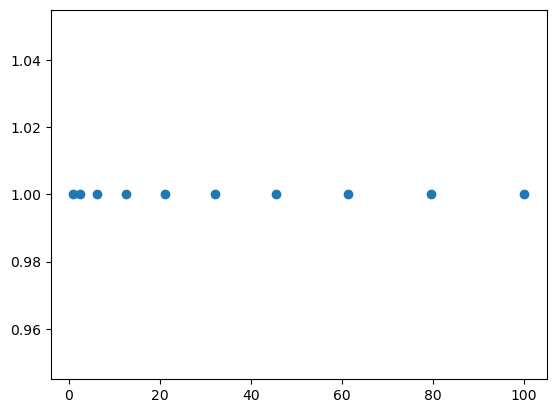

  * Mod_x:    [[1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125, 45.47826086956522, 61.26086956521739, 79.43478260869566, 100.0]]

Simulator...

this should be a single point:  1.0

this should be a single point:  2.4347826086956523

this should be a single point:  6.260869565217392

this should be a single point:  12.478260869565217

this should be a single point:  21.08695652173913

this should be a single point:  32.086956521739125

this should be a single point:  45.47826086956522

this should be a single point:  61.26086956521739

this should be a single point:  79.43478260869566

this should be a single point:  100.0
  * Sim_y:    [-2829.116442128402, -2087.9054321343046, -2223.683822036687, 618.2894954307424, 15853.081271452591, 27568.128639359064, 97161.84692918714, 210043.02504397213, 499914.4118719944, 982101.1524659639]
[1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125,

TypeError: Validator.fit_curve() missing 1 required positional argument: 'y_values'

In [1]:
# PLACEHOLDER FOR THE MAIN FUNCTION V2
from global_settings import mdv
from Validator import Validator
from Modifier import Modifier
from Simulator import Simulator

print(mdv)
#TODO: How to autoreload without restarting kernel (for global vars)
# Instantiate mdv values
# mdv={"domain_min_range":1, "domain_max_range":100, "modifier_incremental_unit":3, "modifier_data_point":10}
# Create an instance of the Validator Class
validate = Validator
modifier = Modifier
simulator = Simulator
appendedvars=[]

mainfunc=True
# Initialize interval list
interval_lists=[(mdv["domain_min_range"], mdv["domain_max_range"])]
x=1
while mainfunc==True:

    # Run Modifier Controller Function
    #TODO: Separate into Modifiers.py file
    mod_x_list= modifier.modifier_controller(range_list=interval_lists,local_modifier=modifier.local_modifier_A, do_plot=True)
    # appendedvars.append(mod_x_list)

    #if data can't be generated:
    if mod_x_list == False: # FALSE IF ["modifier_data_point"] < mdv["modifier_incremental_unit"]:
        print('*   ITERATIONS END HERE   *')
        #TODO: Generate Report
        break

    # Run Simulator Function
    # TODO: Separate functions into a simulators.py file
    # for i in range(np.shape(mod_x_list)[0]):

    mod_x,sim_y_list = simulator.simulator_controller(mod_x_list,selected_function=simulator.sim_func_A)
    print((mod_x))
    print((sim_y_list))
    assert len(mod_x) == len(sim_y_list)
    # Get ranges of unfit points ( IF ANY )

    # Run Validator functions
    ranges = validate.get_unfitting_ranges(mod_x_list=mod_x,sim_y_list=sim_y_list,threshold=0.9)
    # print('these are the ranges of validator\n',ranges)

    ## TODO: Replace for loops with Validator functions that return ranges [(),(),()] format
    if x == 1: 
        ranges = [(0,50),(70,80)]
    elif x == 2:
        ranges = [(30,50),(70,75)]
    elif x==3: 
        ranges = False
    x=x+1
    if mod_x_list == False or not ranges: 
        mainfunc=False
        print('The END')
    interval_lists = ranges


# TODO: 
# Validator needs to work as a loop within itseft that accepts 3 different sets of points
# understand curve fitting
# Fix ranges
